# Phân loại quan điểm trên twitter


## Tóm tắt
Mục tiêu của bài tập này là dự đoán cảm xúc cho bài đăng trên Twitter nhất định bằng Python. Mỗi bài đăng được đánh giá là 1 trong các nhãn: tích cực, tiêu cực và trung tính.

## Các thư viện python
Tiền xử lý dữ liệu sử dụng các thư viện *pandas*, *gensim* and *numpy*, huấn luyện và kiểm tra dùng *scikit-learn*. Vẽ đồ thị sử dụng *plotly*.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/NLP_VINAI/Lesson11/

[Errno 2] No such file or directory: 'drive/MyDrive/NLP_VINAI/Lesson11/'
/content/drive/MyDrive/NLP_VINAI/Lesson11


In [ ]:
from collections import Counter
import nltk
import pandas as pd
import re as regex
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim
import matplotlib.pyplot as plt


# cấu hình thư viện vẽ đồ thị

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dữ liệu nguồn
Dữ liệu đầu vào gồm có 2 CSV: `train.csv` (5971 tweets) and `test.csv` (4000 tweets) - một cho huấn luyện và một cho kiểm tra. Định dạng dữ liệu như sau (dữ liệu kiểm tra không có cột Category column):


| Id | Category  | Tweet |
|------|------|------|
|   635930169241374720  | neutral | IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it |

All tweets are in english, so it simplifies the processing and analysis.


# Tiền xử lý dữ liệu
## Đọc dữ liệu
        

In [ ]:
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "emotion", "text"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative", "neutral"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "text"],dtype={"id":"int64","text":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["text"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

## Câu hỏi 1: Đọc và hiển thị dữ liệu
- Đọc dữ liệu huấn luyện từ file data/train.csv, lưu vào biến data
- hiển thị một vài mẫu dữ liệu

In [ ]:
# Đọc dữ liệu từ file data/train.csv
#### YOUR CODE HERE ####

#Hiển thị một số mẫu dữ liệu
#### YOUR CODE HERE ####

,id,emotion,text
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...


## Trực quan hóa dữ liệu
- Thống kê số mẫu dữ liệu
- Vẽ đồ thị 

956
2888
2125


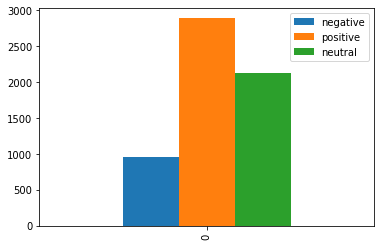

In [ ]:
# tính số mẫu dữ liệu cho mỗi lớp "negative","neutral","positive"
#### YOUR CODE HERE ####

# Vẽ đồ thị cột so sánh số data sample của các lớp
#### YOUR CODE HERE ####

## Câu hỏi 3: Tiền xử lý
Mục tiêu của giai đoạn tiền xử lý nhằm tạo biểu diễn **Bag-of-Words** của dữ liệu. Các bước được tiến hành như sau:
1. Làm sạch
<ol style="list-style-type:decimal"><li>Xóa URLs</li>
<li>Xóa usernames (mentions)</li>
<li>Xóa bài đăng với nội dung *Not Available*</li>
<li>Xóa ký tự đặc biệt</li>
1. Xử lý văn bản
<ol style="list-style-type:decimal">
<li>Tách từ</li>
<li>Chuyển thành chữ thường</li>
<li>Stem</li></ol>
1. Xây dựng danh sách từ cho Bag-of-Words

### Làm sạch
Để làm sạch dữ liệu, chúng ta xây dựng lớp ```TwitterCleanup```. Lớp này bao gồm các phương thức cho phép thực thi tất cả các nội dung đã liệt kê ở trên. Một số công việc chúng ta có thể sử dụng biểu thức chính quy. Lớp này có phương thức ```iterate()``` cho phép thực thi tất cả các phương thức làm sạch theo thứ tự hợp lý.

In [ ]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               ]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "text"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        #Xóa các urls, nên sử dụng regex
        #### YOUR CODE HERE ####

    def remove_na(self, tweets):
        return tweets[tweets["text"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))
    



Dữ liệu các tweets được làm sạch như sau

In [ ]:
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [ ]:
# Tiền xử lý làm sạch dữ liệu: Xóa ký tự không có nghĩa
#### YOUR CODE HERE ####

# Hiển thị một số mẫu dữ liệu sau khi làm sạch để kiểm tra kết quả tiền xử lý
#### YOUR CODE HERE ####

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,emotion,text
1,635930169241374720,neutral,IOS 9 App Transport Security Mm need to check ...
2,635950258682523648,neutral,Mar if you have an iOS device you should downl...
3,636030803433009153,negative,my phone does not run on latest IOS which may ...
4,636100906224848896,positive,Not sure how to start your publication on iOS ...
5,636176272947744772,neutral,Two Dollar Tuesday is here with Forklift 2 Qui...


### Câu hỏi 3.3: Tách từ & stemming
Để xử lý văn bản, chúng ta sử dụng thư viện ```nltk```. Đầu tiên các tweets được tách từ bằng cách sử dụng ```nlkt.word_tokenize``` và sau đó, stemming được thực hiện bằng **PorterStemmer** bởi các tweets đều viết bằng tiếng Anh.

In [ ]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["text"] = list(map(lambda str: stemmer.stem(str.lower()), row["text"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            # tách từ cho từng dòng
            #### YOUR CODE HERE ####
            return row

        self.processed_data = self.#### YOUR CODE HERE ####cessed_data.apply(tokenize_row, axis=1)


In [ ]:
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data.head(5)

,id,emotion,text,tokenized_text
1,635930169241374720,neutral,"[io, 9, app, transport, secur, mm, need, to, c...","[IOS, 9, App, Transport, Security, Mm, need, t..."
2,635950258682523648,neutral,"[mar, if, you, have, an, io, devic, you, shoul...","[Mar, if, you, have, an, iOS, device, you, sho..."
3,636030803433009153,negative,"[my, phone, doe, not, run, on, latest, io, whi...","[my, phone, does, not, run, on, latest, IOS, w..."
4,636100906224848896,positive,"[not, sure, how, to, start, your, public, on, ...","[Not, sure, how, to, start, your, publication,..."
5,636176272947744772,neutral,"[two, dollar, tuesday, is, here, with, forklif...","[Two, Dollar, Tuesday, is, here, with, Forklif..."


## Câu hỏi 4: Xây dựng danh sách từ
### Câu hỏi 4.1 Lập từ điển
Danh sách từ (từ điển) được xây dựng bằng cách đến số lần xuất hiện các từ trong toàn bộ cơ sở dữ liệu.

In [ ]:
# Xây dựng từ điển, thống kê số lần xuất hiện các từ
#### YOUR CODE HERE ####

# Hiển thị 1 số từ có tần suất xuất hiện lớn nhất
#### YOUR CODE HERE ####

[('the', 4294), ('to', 2495), ('a', 1680), ('i', 1667), ('on', 1581)]

### Câu hỏi 4.2 Xóa các từ stop words
Các từ phổ biến nhất thường là các từ stopwords trong tiếng Anh. Tuy nhiên, chúng tôi sẽ lọc chúng ra, vì mục đích của phân tích này là để xác định tình cảm, những từ như "not" và "n't" có thể ảnh hưởng đến nó rất nhiều. Vì lý do này, từ này sẽ được đưa vào danh sách trắng.

In [ ]:
# Xóa các từ stop word
#### YOUR CODE HERE ####

# Hiển thị 1 số từ có tần suất xuất hiện lớn nhất
#### YOUR CODE HERE ####

[('may', 1032), ('tomorrow', 766), ('day', 526), ('go', 502), ('thi', 499)]

Tuy nhiên, có một số từ xuất hiện quá nhiều lần, chúng có thể bị lọc. Dựa trên một số phân tích, cận dưới được đặt là 3.
Danh sách từ được lưu vào tệp csv, vì vậy các từ tương tự có thể được sử dụng cho tập thử nghiệm.


In [ ]:
class TwitterData_Wordlist(TwitterData_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    whitelist = ["n't","not"]
    wordlist = []
        
    def build_wordlist(self, min_occurrences=3, max_occurences=500, stopwords=nltk.corpus.stopwords.words("english"),
                       whitelist=None):
        self.wordlist = []
        whitelist = self.whitelist if whitelist is None else whitelist
        import os
        if os.path.isfile("data\\wordlist.csv"):
            word_df = pd.read_csv("data\\wordlist.csv")
            word_df = word_df[word_df["occurrences"] > min_occurrences]
            self.wordlist = list(word_df.loc[:, "word"])
            return

        words = Counter()
        for idx in self.processed_data.index:
            words.update(self.processed_data.loc[idx, "text"])

        for idx, stop_word in enumerate(stopwords):
            if stop_word not in whitelist:
                del words[stop_word]

        word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                     "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                               columns=["word", "occurrences"])

        word_df.to_csv("data\\wordlist.csv", index_label="idx")
        self.wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]


In [ ]:
data = TwitterData_Wordlist(data)
data.build_wordlist()

## Câu hỏi 4.3: Đọc danh sách các từ trong file vừa lưu

In [ ]:
# đọc các từ trong file wordlist.csv
#### YOUR CODE HERE ####

#### YOUR CODE HERE ####

['one', 'amp', 'like', 'get', 'time', 'see', 'im', 'not', 'wa', 'thi', 'go']
[285, 301, 344, 348, 359, 372, 374, 426, 483, 495, 499]


### Câu hỏi 5: Xây dựng túi từ
Dữ liệu sẵn sàng chuyển thành biểu diễn bag-of-words.

In [ ]:
class TwitterData_BagOfWords(TwitterData_Wordlist):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        self.wordlist = previous.wordlist
    
    def build_data_model(self):
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + list(
            map(lambda w: w + "_bow",self.wordlist))
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "text"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels

### Câu hỏi 5.1: Sinh vector biểu diễn cho các tweets
- Sinh biểu diễn Bag of words cho các tweets.


In [ ]:
# sinh đặc trưng Bag of words cho các tweets
#### YOUR CODE HERE ####

# Hiển thị vector của một số mẫu
#### YOUR CODE HERE ####

,label,go_bow,thi_bow,wa_bow,not_bow,im_bow,see_bow,time_bow,get_bow,like_bow,...,leadership_bow,snp_bow,tsiprass_bow,parliamentari_bow,alexi_bow,farag_bow,girlfriend_bow,castl_bow,crasher_bow,fiddl_bow
0,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,negative,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,positive,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Câu hỏi 6: Phân loại

In [ ]:
import random
seed = 666
random.seed(seed)

### Câu hỏi 6.1 Xây dựng bộ phân lớp
Huấn luyện bộ phân lớp, hiểu thị F1, precision, recall, và accuracy.

In [ ]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    log("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    
    # huấn luyện mô hình
    #### YOUR CODE HERE ####
    log("Learing time {0}s".format(time() - now))
    now = time()
    
    # dự đoán kết quả trên tập test
    #### YOUR CODE HERE ####
    log("Predicting time {0}s".format(time() - now))
    
    
    # tính toán các độ đo precision, recall, accuracy
    #### YOUR CODE HERE ####
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)

### Câu hỏi 6.2 Thực nghiệm 1: BOW + Naive Bayes
Biểu diễn bag-of-words là nhị phân, do đó, Naive Bayes Classifier là một thuật toán tốt để bắt đầu thử nghiệm.

Tập dữ liệu được chia train:test theo tỉ lệ `` 75: 25 ''

In [ ]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow.iloc[:, 0],
                                                    train_size=0.75, stratify=bow.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())


Testing BernoulliNB
Learing time 0.3307375907897949s
Predicting time 0.05487179756164551s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.39361702 0.46137106 0.70712773]
Precision[0.46540881 0.49302326 0.65319426]
Recall   [0.34101382 0.43353783 0.77076923]
Accuracy 0.5803834808259587


### Câu hỏi 6.3 Thực nghiệm với 5-fold cross validation

In [ ]:
#### YOUR CODE HERE ####

In [ ]:
nb_acc = cv(BernoulliNB(), bow.iloc[:,1:], bow.iloc[:,0])

Crossvalidating BernoulliNB...
Crosvalidation completed in 2.847633123397827s
Accuracy: [0.55014749 0.49852507 0.27581121 0.30973451 0.33923304 0.50664697
 0.46085672 0.53914328]
Average accuracy: 0.43501228742107945
